#### ***Objetivo***

Este trabalho tem como objetivo desenvolver e avaliar um **sistema de recomendação de filmes** utilizando o dataset **MovieLens (ml-latest-small)**.  
Serão aplicadas técnicas de **filtragem colaborativa** e **filtragem baseada em conteúdo**, explorando a possibilidade de combinar abordagens em um modelo híbrido para prever avaliações de usuários e gerar recomendações personalizadas.

O problema central a ser tratado é a **dificuldade dos usuários em escolher conteúdos relevantes diante de grandes catálogos digitais**, realidade que afeta diretamente a experiência em plataformas de streaming e outros serviços baseados em mídia. O MovieLens foi escolhido por sua ampla utilização acadêmica, riqueza de informações e adequação para experimentação prática.

A pesquisa busca responder à seguinte questão:  
    *É possível antecipar os gostos cinematográficos dos usuários e surpreendê-los com recomendações relevantes utilizando apenas suas avaliações e tags, combinando técnicas de filtragem colaborativa, baseada em conteúdo e modelos híbridos?*

Do ponto de vista prático, o projeto contribui para:  
- **Usuários finais**: oferecer sugestões mais personalizadas, reduzindo a sobrecarga de escolha.  
- **Profissionais de ciência de dados**: aplicar técnicas de machine learning em um contexto realista e replicável.  
- **Equipes de produto**: compreender como algoritmos de recomendação podem influenciar métricas de engajamento, retenção e satisfação.  

Assim, o estudo alia **conhecimento teórico** e **aplicação prática**, aproximando a pesquisa acadêmica de desafios concretos enfrentados por plataformas digitais de entretenimento e comércio eletrônico.

#### ***Importação de bibliotecas e carregamento dos datasets***

Nesta primeira etapa, foram importadas as bibliotecas necessárias para manipulação e análise dos dados:

- **pandas**: manipulação de tabelas (DataFrames).  
- **numpy**: suporte para cálculos numéricos e estatísticos.  
- **matplotlib.pyplot**: geração de gráficos.  
- **os** e **re**: manipulação de arquivos e expressões regulares.  
- **json**: suporte para exportações/estruturas em formato JSON.

In [2]:
import pandas as pd
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity

#### ***Foram carregados os quatro arquivos CSV disponibilizados pelo **MovieLens (ml-latest-small)**, armazenados no diretório `archive/`:***

- `movies.csv` → contém informações dos filmes (título, ano e gêneros).  
- `ratings.csv` → avaliações atribuídas pelos usuários.  
- `tags.csv` → marcações (tags) aplicadas pelos usuários aos filmes.  
- `links.csv` → identificadores externos para bases como IMDb e TMDb.

In [3]:
# Caminho da pasta com os CSVs
data_dir = "data"

movies = pd.read_csv(os.path.join(data_dir, "movies.csv"), sep=',')
ratings = pd.read_csv(os.path.join(data_dir, "ratings.csv"), sep=',')
tags = pd.read_csv(os.path.join(data_dir, "tags.csv"), sep=',')
links = pd.read_csv(os.path.join(data_dir, "links.csv"), sep=',')

print("Arquivos carregados com sucesso!")


Arquivos carregados com sucesso!


## ***Trabalhando com movies.csv***

#### ***Visão inicial do `movies` (amostra do topo e do final)***

Antes de qualquer transformação, olhei as **primeiras** e as **últimas** linhas da tabela `movies`.  
Essa passada de olho ajuda a entender rapidamente o “jeito” dos dados e se está tudo coerente.

**O que aparece aqui:**
- `movieId`: um identificador numérico único de cada filme (é a nossa chave para juntar com outras tabelas).
- `title`: o título como veio no dataset, geralmente com o ano entre parênteses (ex.: `Toy Story (1995)`).
- `genres`: os gêneros do filme, separados por `|` (ex.: `Adventure|Animation|Children|Comedy|Fantasy`).

**Por que isso importa:**
- O `movieId` é a coluna que vamos usar em todos os *merges* (com `ratings`, `tags` e `links`).
- O `title` vai passar por uma limpeza simples para padronizar o texto e separar o **ano**.
- A coluna `genres` será transformada mais adiante em **colunas binárias** (one-hot) para apoiar a recomendação baseada em conteúdo.

**Primeiras impressões:**
- Os títulos parecem seguir o padrão “Nome do filme (ANO)”, o que facilita extrair o ano.
- Os gêneros vêm concatenados por `|`, então já sabemos como quebrar e codificar.
- Ver o topo e o final do arquivo dá confiança de que o carregamento foi correto e sem truncamentos.

> Resumo: a estrutura está limpa e direta, bem adequada para as etapas de padronização que virão (título, ano e gêneros).


In [4]:
display('Visualizando o topo dos dados:', movies.head(), 'Visualizando o final dos dados:', movies.tail())

'Visualizando o topo dos dados:'

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


'Visualizando o final dos dados:'

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


#### ***Estrutura e dimensionalidade do dataset `movies`***

Com o comando `movies.info()`, verifiquei a estrutura da tabela e a qualidade das colunas. O resultado mostra:

- **Total de registros**: 9.742 linhas.  
- **Colunas**: 3 (`movieId`, `title`, `genres`).  
- **Tipos de dados**:
  - `movieId` → inteiro (`int64`)
  - `title` → texto (`object`)
  - `genres` → texto (`object`)
- **Valores nulos**: não existem (`Non-Null Count` é igual ao total de linhas em todas as colunas).  

Em seguida, comparei a quantidade de **IDs únicos** com o número total de linhas:

- **IDs únicos**: 9.742  
- **Total de linhas**: 9.742  

Isso confirma que **cada `movieId` aparece apenas uma vez**, ou seja, não há duplicação de filmes no dataset. Esse é um ponto muito importante, porque garante que podemos usar `movieId` como **chave primária** para juntar de forma segura com as tabelas `ratings`, `tags` e `links`.

In [5]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [6]:
print(f"IDs únicos: {movies['movieId'].nunique()}")
print(f"Total de linhas: {len(movies)}")

IDs únicos: 9742
Total de linhas: 9742


#### ***Extração do ano de lançamento***

Como o campo `title` traz o nome do filme junto com o ano entre parênteses (ex.: *Toy Story (1995)*), foi necessário separar essas duas informações.  
Para isso, utilizei uma **expressão regular (regex)** que captura os 4 dígitos finais entre parênteses, criando a coluna `year`.

Agora, a tabela `movies` conta com uma nova coluna:
- `year` (novo campo, numérico extraído do título)  

**Por que fazer isso?**
- Ter o **ano em uma coluna separada** permite análises ao longo do tempo (como número de filmes lançados por Ano).  
- Facilita filtros (ex.: “recomendar apenas filmes mais atuais”).  
- Mantém o título mais limpo, deixando apenas o nome do filme para exibição ao usuário.

Esse é um passo importante de **pré-processamento**, pois transforma dados textuais em variáveis estruturadas que podemos usar em análises estatísticas e em sistemas de recomendação.


In [7]:
# Separando título e ano
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

movies

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018


#### ***Limpeza e Padronização dos Títulos***

Os títulos originais dos filmes no dataset vinham acompanhados do ano de lançamento entre parênteses, além de apresentarem inconsistências de formatação, como diferenças no uso de maiúsculas e minúsculas ou presença de siglas e numerais em formatos variados. Essas inconsistências poderiam prejudicar futuras análises, já que títulos escritos de formas diferentes seriam interpretados como filmes distintos.

Para resolver esse problema, criamos a função **`normalize_title`**, que aplica uma série de transformações:

1. **Remoção do ano**  
   O ano entre parênteses no final do título foi retirado, pois essa informação já está armazenada em outra coluna (`year`).

2. **Padronização para *Title Case***  
   Cada palavra do título passa a começar com letra maiúscula, garantindo uniformidade.  
   Exemplos:  
   - *"toy story"* → **"Toy Story"**  
   - *"waiting to exhale"* → **"Waiting To Exhale"**

3. **Correção de numerais romanos**  
   Numerais romanos (II, III, IV, VI etc.) foram padronizados em caixa alta, evitando situações como *"Rocky ii"* ou *"Star Wars iv"*.

4. **Ajuste de siglas comuns**  
   Algumas siglas importantes, como **USA, UK, IMAX, 3D**, foram preservadas em caixa alta para manter a legibilidade.

5. **Remoção de espaços desnecessários**  
   Espaços duplicados ou no início/fim foram eliminados.

---

In [8]:
def normalize_title(title: str) -> str:
    if pd.isna(title):
        return title

    # Remove o ano (no final entre parênteses)
    title = re.sub(r"\s*\(\d{4}\)\s*$", "", title).strip()

    # Aplica Title Case
    title = title.title()

    # Corrige numerais romanos (II, III, IV, VI, VII, VIII, IX, X)
    roman_pattern = r"\b(I|Ii|Iii|Iv|Vi|Vii|Viii|Ix|X)\b"
    title = re.sub(roman_pattern, lambda m: m.group(1).upper(), title)

    # Corrige algumas siglas comuns
    siglas = ["USA", "UK", "IMAX", "3D", "II", "III", "IV", "VI", "VII", "VIII", "IX", "X"]
    for s in siglas:
        title = re.sub(rf"\b{s.title()}\b", s, title)

    # Remove espaços múltiplos (se houver)
    title = re.sub(r"\s+", " ", title).strip()

    return title

In [9]:
movies["title_clean"] = movies["title"].apply(normalize_title)

# Conferir alguns exemplos
movies[["title", "title_clean"]]


,title,title_clean
0,Toy Story (1995),Toy Story
1,Jumanji (1995),Jumanji
2,Grumpier Old Men (1995),Grumpier Old Men
3,Waiting to Exhale (1995),Waiting To Exhale
4,Father of the Bride Part II (1995),Father Of The Bride Part II
...,...,...
9737,Black Butler: Book of the Atlantic (2017),Black Butler: Book Of The Atlantic
9738,No Game No Life: Zero (2017),No Game No Life: Zero
9739,Flint (2017),Flint
9740,Bungo Stray Dogs: Dead Apple (2018),Bungo Stray Dogs: Dead Apple


### 📌 Extração e Conversão do Ano de Lançamento

Realizamos a conversão dos valores para o tipo numérico (`Int64`), garantindo que o ano possa ser tratado de forma consistente em cálculos e estatísticas. Também foram tratados casos em que o ano não estava presente no título (nesse caso, o valor fica como *NaN*).

---

### ✅ Estatísticas Descritivas do Ano

O método `.describe()` gera estatísticas descritivas que ajudam a entender melhor a distribuição dos dados.  
No caso da coluna **`year`**, os resultados foram:

- **count (9729)** → Quantidade de registros não nulos (ou seja, quantos filmes possuem ano de lançamento identificado).  
- **mean (1994.6)** → Média dos anos, mostrando que em média os filmes foram lançados por volta de 1995.  
- **std (18.53)** → Desvio padrão, que mede a dispersão em relação à média. Aqui indica que, em geral, os anos de lançamento variam cerca de 18 anos para mais ou para menos em relação à média.  
- **min (1902)** → Ano mais antigo registrado na base (primeiros filmes catalogados).  
- **25% (1988)** → Primeiro quartil: 25% dos filmes foram lançados até 1988.  
- **50% (1999)** → Mediana: metade dos filmes foi lançada até 1999.  
- **75% (2008)** → Terceiro quartil: 75% dos filmes foram lançados até 2008.  
- **max (2018)** → Ano mais recente encontrado no dataset.

Esses números indicam que a base de dados cobre mais de um século de produções cinematográficas, indo desde filmes do início do século XX até lançamentos recentes de 2018.


In [10]:
# Converte year para numérico
movies["year"] = pd.to_numeric(movies["year"], errors="coerce").astype('Int64')

movies['year'].describe()

count         9729.0
mean     1994.613629
std        18.535219
min           1902.0
25%           1988.0
50%           1999.0
75%           2008.0
max           2018.0
Name: year, dtype: Float64

In [11]:
movies

,movieId,title,genres,year,title_clean
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Jumanji
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Grumpier Old Men
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Waiting To Exhale
4,5,Father of the Bride Part II (1995),Comedy,1995,Father Of The Bride Part II
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017,Black Butler: Book Of The Atlantic
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,No Game No Life: Zero
9739,193585,Flint (2017),Drama,2017,Flint
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,Bungo Stray Dogs: Dead Apple


#### ***Tratamento dos Gêneros dos Filmes***

A coluna **`genres`** contém os gêneros de cada filme, separados por `|`.  

Essa estrutura em forma de lista de strings não é ideal para análises e modelagem, pois dificulta cálculos e agrupamentos. Para resolver, seguimos os seguintes passos:

---

#### 1. Limpeza dos valores
- O valor `(no genres listed)` foi substituído por **NaN**, evitando que apareça como um gênero “falso”.
- Espaços vazios foram preenchidos com string vazia (`""`).

---

#### 2. Transformação para One-Hot Encoding
Aplicamos o método **`str.get_dummies(sep="|")`**, que cria uma nova coluna para cada gênero.  
Cada coluna indica, com valores **0 ou 1**, se o filme pertence ou não a esse gênero.

Exemplo simplificado:

| Título       | Gêneros Originais                  | Action | Adventure | Comedy |
|--------------|------------------------------------|--------|-----------|--------|
| Toy Story    | Adventure\|Animation\|Children\|Comedy |   0    |     1     |   1    |
| Jumanji      | Adventure\|Children\|Fantasy       |   0    |     1     |   0    |
| Heat         | Action\|Crime\|Thriller            |   1    |     0     |   0    |

---

#### 3. Junção ao DataFrame original
As colunas binárias foram adicionadas ao dataframe `movies`, gerando o dataframe final **`movies_ohe`**, com o seguinte formato:

- **9.742 linhas** (um registro por filme)  
- **24 colunas**, incluindo:
  - `movieId`, `title`, `genres`, `year`, `title_clean`
  - 19 colunas de gêneros (Action, Comedy, Drama, etc.)

---

### Benefícios do One-Hot Encoding
O **One-Hot Encoding (OHE)** é uma técnica usada para transformar variáveis categóricas em variáveis numéricas, de forma que possam ser entendidas por algoritmos de análise e modelos de Machine Learning.
- Permite **contar quantos filmes existem em cada gênero**.  
- Facilita análises estatísticas e construção de gráficos.  
- Torna os dados **compatíveis com algoritmos de Machine Learning**, que precisam de variáveis numéricas.  
- Permite criar **recomendações por similaridade de gênero**.

---

A tabela **`movies_ohe`** será a base final de filmes utilizada nas próximas análises e cruzamentos com as demais tabelas (`ratings`, `tags`, `links`).


In [12]:
# Evite "Unknown" no OHE: deixe vazio/NaN para não virar uma "categoria"
genres_clean = movies["genres"].replace("(no genres listed)", np.nan).fillna("")

In [13]:
# One-Hot com separador "|"
genres_ohe = genres_clean.str.get_dummies(sep="|")

In [14]:
genres_ohe

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9738,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9739,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9740,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
# Junta ao dataframe original
movies_ohe = pd.concat([movies, genres_ohe], axis=1)

In [16]:
print("Formato do OHE:", movies_ohe.shape)
display(movies_ohe)

Formato do OHE: (9742, 24)


,movieId,title,genres,year,title_clean,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995,Jumanji,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,1995,Grumpier Old Men,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995,Waiting To Exhale,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1995,Father Of The Bride Part II,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017,Black Butler: Book Of The Atlantic,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,No Game No Life: Zero,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
9739,193585,Flint (2017),Drama,2017,Flint,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,Bungo Stray Dogs: Dead Apple,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


#### ***Versão "Explodida" por Gênero***

Até aqui, vimos que cada filme pode ter **vários gêneros ao mesmo tempo**, armazenados juntos na coluna `genres` e separados por `|`.  

Esse formato é útil para leitura humana, mas para algumas análises ele pode atrapalhar.  
Por exemplo: se quisermos **contar quantos filmes existem por gênero**, precisamos separar esses valores.

### O que foi feito
1. A coluna `genres` foi **separada** (`split`) em uma lista de gêneros.  
2. Em seguida, usamos a função `explode`, que cria **uma nova linha para cada gênero**.  

Isso significa que:  
- O filme **Toy Story (1995)**, que tinha 5 gêneros, agora aparece em **5 linhas diferentes**, cada uma com um gênero único.  


### Exemplo
Antes do `explode`:
| movieId | title           | genres                                   |
|---------|-----------------|------------------------------------------|
| 1       | Toy Story (1995)| Adventure\|Animation\|Children\|Comedy\|Fantasy |

Depois do `explode`:
| movieId | title           | genre     |
|---------|-----------------|-----------|
| 1       | Toy Story (1995)| Adventure |
| 1       | Toy Story (1995)| Animation |
| 1       | Toy Story (1995)| Children  |
| 1       | Toy Story (1995)| Comedy    |
| 1       | Toy Story (1995)| Fantasy   |


### Vantagens da versão "explodida"
- Permite fazer **contagens de filmes por gênero** facilmente.  
- Facilita a construção de **tabelas de frequência** (ex.: top 10 gêneros mais comuns).  
- Torna possível cruzar gêneros com outras variáveis, como ano de lançamento ou nota média.  


Em resumo: a versão "explodida" é como se pegássemos os filmes multigênero e os “abríssemos” em várias linhas, garantindo que cada linha tenha apenas **um único gênero**.


In [17]:
# Versão "explodida" por gênero (útil para contagens e tabelas)
movies_exploded = (
    movies.assign(genre = genres_clean.str.split("|"))
          .explode("genre")
)

# Remove linhas vazias (filmes sem gênero)
movies_exploded = movies_exploded[movies_exploded["genre"].notna() & (movies_exploded["genre"]!="")]

display(movies_exploded)
print("Linhas na versão explodida:", len(movies_exploded))

,movieId,title,genres,year,title_clean,genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Adventure
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Animation
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Children
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Comedy
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995,Toy Story,Fantasy
...,...,...,...,...,...,...
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017,No Game No Life: Zero,Fantasy
9739,193585,Flint (2017),Drama,2017,Flint,Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,Bungo Stray Dogs: Dead Apple,Action
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018,Bungo Stray Dogs: Dead Apple,Animation


Linhas na versão explodida: 22050


#### ***Número de gêneros por filme***

Cada filme pode estar associado a múltiplos gêneros. Para quantificar essa informação, somamos os valores `1` de cada linha no DataFrame one-hot (`genres_ohe`), obtendo a coluna `n_genres`.

Essa coluna mostra quantos gêneros cada filme possui, permitindo análises como:

- A distribuição da quantidade de gêneros nos filmes.
- Identificação de filmes mais “multigênero”.
- Comparações com outras variáveis, como ano de lançamento ou popularidade.

Essa etapa é importante porque nem todos os filmes possuem apenas um gênero. Muitos títulos combinam **2 a 3 categorias**, e alguns chegam a 5 ou mais, o que pode influenciar nos resultados de recomendações.


In [18]:
n_genres = genres_ohe.sum(axis=1)
movies_ohe["n_genres"] = n_genres
movies_ohe[['genres','n_genres']]

,genres,n_genres
0,Adventure|Animation|Children|Comedy|Fantasy,5
1,Adventure|Children|Fantasy,3
2,Comedy|Romance,2
3,Comedy|Drama|Romance,3
4,Comedy,1
...,...,...
9737,Action|Animation|Comedy|Fantasy,4
9738,Animation|Comedy|Fantasy,3
9739,Drama,1
9740,Action|Animation,2


#### ***Análise da distribuição de gêneros no catálogo***

Nesta etapa, foi analisada a **estrutura do catálogo de filmes**, com foco na quantidade de gêneros associados a cada título e na frequência absoluta de cada gênero.


Esses números indicam que, em média, cada filme está associado a 2 gêneros. A maioria dos títulos possui entre 1 e 3 categorias, embora existam casos atípicos, como filmes sem gênero registrado (34) e um filme com 10 gêneros simultâneos.

In [19]:
print("Número total de filmes:", len(movies_ohe))
print("Número de gêneros distintos:", genres_ohe.shape[1])
print("Média de gêneros por filme:", n_genres.mean().round(3))
print("Mediana de gêneros por filme:", n_genres.median())
print("Moda de gêneros por filme:", n_genres.mode().iat[0])
print("Desvio padrão:", n_genres.std(ddof=1).round(3))
print("Mínimo / Máximo:", int(n_genres.min()), "/", int(n_genres.max()))

Número total de filmes: 9742
Número de gêneros distintos: 19
Média de gêneros por filme: 2.263
Mediana de gêneros por filme: 2.0
Moda de gêneros por filme: 2
Desvio padrão: 1.129
Mínimo / Máximo: 0 / 10


A tabela de frequência revela a seguinte distribuição:

- 34 filmes não possuem gênero atribuído.  
- A maior parte dos títulos possui **1 gênero (2.817 filmes)** ou **2 gêneros (3.218 filmes)**.  
- Um número considerável também possui **3 gêneros (2.338 filmes)**.  
- Casos com 5 ou mais gêneros são raros e podem ser considerados exceções.  

Isso confirma que os filmes, em geral, são classificados de forma simples, o que facilita a categorização e futuras análises.


In [20]:
# Tabela de distribuição (quantos filmes têm 0, 1, 2, ... gêneros)
dist = n_genres.value_counts().sort_index()
display(dist.to_frame(name="qtd_filmes"))

,qtd_filmes
0,34
1,2817
2,3218
3,2338
4,987
5,271
6,63
7,12
8,1
10,1


Esses resultados destacam que o catálogo é dominado por categorias amplas e populares, o que é consistente com a produção cinematográfica global.


In [21]:
# Gêneros mais frequentes (contagem)
genre_counts = genres_ohe.sum().sort_values(ascending=False)
topN = 15  # ajuste aqui se quiser mais/menos
display(genre_counts.head(topN).to_frame(name="qtd_filmes"))

,qtd_filmes
Drama,4361
Comedy,3756
Thriller,1894
Action,1828
Romance,1596
Adventure,1263
Crime,1199
Sci-Fi,980
Horror,978
Fantasy,779


- Esta análise evidencia a **composição do catálogo de filmes**, e não o comportamento dos usuários.  
- O catálogo é predominantemente formado por filmes de **Drama** e **Comédia**, sugerindo que essas categorias possuem maior representatividade na base.  
- A grande maioria dos filmes possui entre **1 e 3 gêneros**, refletindo uma categorização relativamente simples.  
- Casos extremos (sem gênero ou com até 10 gêneros) podem ser tratados como **anomalias** em etapas futuras.  
- A análise de **consumo** (quais gêneros são mais assistidos ou bem avaliados) será possível apenas quando cruzarmos estes dados com o dataset de **ratings**.

#### ***Gráficos***
**Histograma do número de gêneros por filme**

O gráfico abaixo mostra a distribuição da quantidade de gêneros atribuídos a cada filme.  

#### Interpretação

- A maior concentração de filmes ocorre entre **1 e 3 gêneros**, confirmando o que já havíamos observado nas estatísticas descritivas.  
- O **pico da distribuição** está nos filmes com **2 gêneros**, que são mais comuns no catálogo.  
- Filmes com **4 ou mais gêneros** aparecem em menor quantidade, sendo considerados menos usuais.  
- Casos extremos, como filmes sem nenhum gênero registrado ou com até 10 categorias, aparecem como outliers e podem indicar inconsistências no cadastro.  

Esse gráfico ajuda a visualizar a tendência geral do catálogo: a maioria dos filmes é classificada de forma simples, em poucas categorias, o que facilita o agrupamento e análises posteriores. 

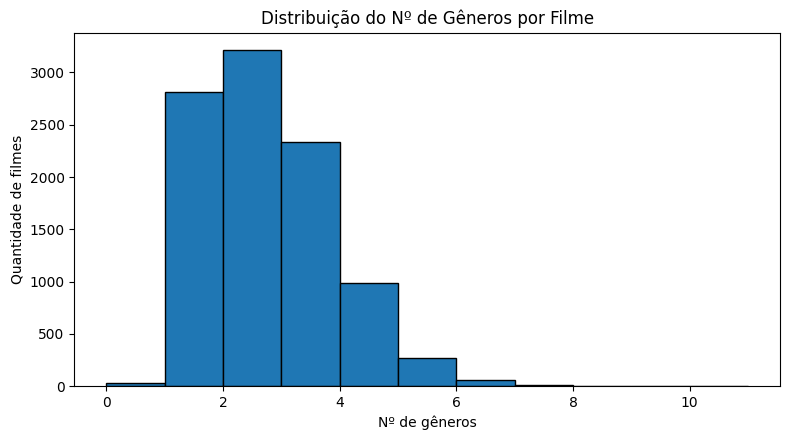

In [22]:
# Histograma do nº de gêneros por filme
plt.figure(figsize=(8,4.5))
plt.hist(movies_ohe["n_genres"], bins=range(int(movies_ohe["n_genres"].max())+2), edgecolor="black")
plt.title("Distribuição do Nº de Gêneros por Filme")
plt.xlabel("Nº de gêneros")
plt.ylabel("Quantidade de filmes")
plt.tight_layout()
plt.show()

**Gêneros mais frequentes no catálogo***

O gráfico abaixo mostra os 15 gêneros mais representados no dataset de filmes, considerando a frequência de títulos associados a cada categoria.


#### Interpretação

- Os gêneros **Drama** (4.361 filmes) e **Comédia** (3.756 filmes) se destacam fortemente, representando quase metade de todo o catálogo analisado.  
- Em seguida, aparecem gêneros como **Thriller** (1.894 filmes) e **Ação** (1.828 filmes), também com presença significativa.  
- Categorias como **Documentário**, **Mistério** e **Guerra** possuem representatividade bem menor, com menos de 600 filmes cada.  

Esses resultados indicam que o dataset é composto principalmente por gêneros amplos e populares, enquanto nichos mais específicos aparecem em menor escala.  
Essa informação é relevante para futuros sistemas de recomendação, já que a maior diversidade em gêneros dominantes pode facilitar sugestões personalizadas, mas também pode gerar **tendência de concentração** nas recomendações.


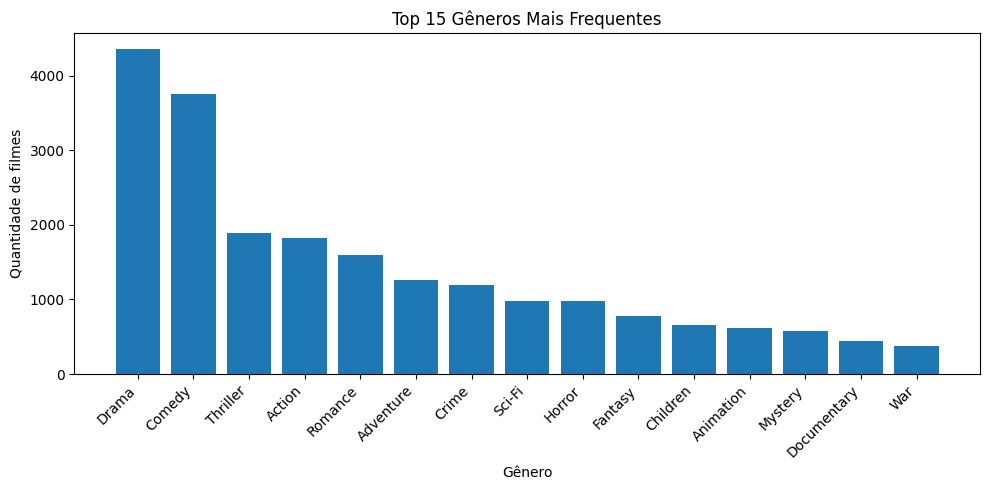

In [23]:
# Barras dos gêneros mais frequentes
top = genre_counts.head(topN)
plt.figure(figsize=(10,5))
plt.bar(top.index, top.values)
plt.title(f"Top {topN} Gêneros Mais Frequentes")
plt.xlabel("Gênero")
plt.ylabel("Quantidade de filmes")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [24]:
# Resumo estatístico do nº de gêneros
summary = pd.Series({
    "n_filmes": len(movies_ohe),
    "n_generos_distintos": genres_ohe.shape[1],
    "media_generos_por_filme": n_genres.mean(),
    "mediana_generos_por_filme": n_genres.median(),
    "moda_generos_por_filme": n_genres.mode().iat[0],
    "desvio_padrao": n_genres.std(ddof=1),
    "min_generos": n_genres.min(),
    "max_generos": n_genres.max(),
}).round(3)

display(summary.to_frame(name="valor"))


,valor
n_filmes,9742.000
n_generos_distintos,19.000
media_generos_por_filme,2.263
mediana_generos_por_filme,2.000
moda_generos_por_filme,2.000
desvio_padrao,1.129
min_generos,0.000
max_generos,10.000


In [25]:
# Top gêneros em formato de tabela
top_generos_df = genre_counts.reset_index()
top_generos_df.columns = ["genero", "qtd_filmes"]
display(top_generos_df.head(topN))

,genero,qtd_filmes
0,Drama,4361
1,Comedy,3756
2,Thriller,1894
3,Action,1828
4,Romance,1596
5,Adventure,1263
6,Crime,1199
7,Sci-Fi,980
8,Horror,978
9,Fantasy,779


***Evolução do Lançamento de Filmes por Ano***

***Quantidade de Filmes ao Longo do Tempo***

O gráfico de linha abaixo mostra a contagem de filmes lançados por ano, com base no dataset analisado:

- **1900–1950**: Produção ainda tímida, com poucos lançamentos por ano.  
- **1960–1980**: Crescimento gradual, indicando maior consolidação da indústria do cinema.  
- **1990–2010**: Forte aceleração, atingindo o pico com **mais de 300 filmes lançados em alguns anos**.  
- **2015 em diante**: Observa-se uma queda brusca, possivelmente relacionada a:
  - Incompletude do dataset nos anos mais recentes (nem todos os filmes cadastrados).  
  - Alterações na forma de registro e coleta dos dados.  

👉 **Interpretação:**  
O auge da produção cinematográfica se dá entre **1995 e 2010**, refletindo a globalização da indústria, expansão de estúdios e maior acesso a tecnologia de filmagem.  
A queda após 2015 deve ser interpretada com cautela, pois é provável que seja **viés de coleta de dados** e não necessariamente uma redução real da produção.


<Axes: xlabel='year'>

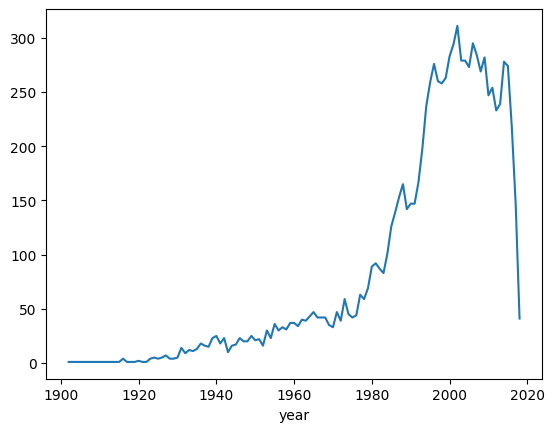

In [26]:
movies.groupby("year")["movieId"].count().plot(kind="line")


***Observações***
- O filme **Rubber (2010)** aparece com **10 gêneros diferentes**, o que é bastante incomum.  
- A maioria dos filmes desse ranking possui entre **7 e 8 gêneros**, sugerindo que alguns títulos foram classificados de forma bastante abrangente.  
- Esse tipo de distribuição pode indicar:
  - **Riqueza temática** do filme (mistura de muitos estilos narrativos).  
  - **Ruído nos dados** (classificação ampla demais ou inconsistências no dataset). 

In [27]:
movies_ohe["n_genres"] = movies_ohe[genres_ohe.columns].sum(axis=1)
movies_ohe[['title', 'n_genres']].sort_values("n_genres", ascending=False).head(10)

,title,n_genres
7441,Rubber (2010),10
5556,Patlabor: The Movie (Kidô keisatsu patorebâ: T...,8
7170,Aelita: The Queen of Mars (Aelita) (1924),7
1390,Mulan (1998),7
5819,Robots (2005),7
6626,Enchanted (2007),7
2250,Who Framed Roger Rabbit? (1988),7
7550,Mars Needs Moms (2011),7
6145,Pulse (2006),7
7467,Tangled (2010),7


***Boxplot da Distribuição de Gêneros por Filme***

O boxplot abaixo mostra a **distribuição do número de gêneros atribuídos por filme**:

- **Linha laranja (mediana)**: A maioria dos filmes tem **2 gêneros**.  
- **Caixa (intervalo interquartil - IQR)**: Representa os filmes entre o 1º quartil (1 gênero) e o 3º quartil (3 gêneros).  
- **Bigodes (linhas horizontais)**: Indicam a variação "normal" dos dados, até cerca de **6 gêneros**.  
- **Outliers (pontos fora da caixa)**: Filmes que possuem uma quantidade incomum de gêneros, variando de **7 até 10 gêneros**.

Observações
- A maior parte dos filmes está concentrada entre **1 e 3 gêneros**, confirmando os resultados anteriores.  
- Existem **poucos filmes multigênero extremos** (com 7 a 10 gêneros), que destoam do padrão.  
- Esse tipo de visualização ajuda a detectar **tendências centrais** e **valores fora do comum** no dataset.


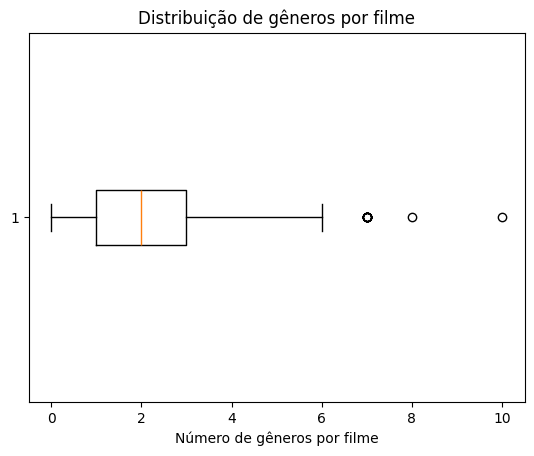

In [28]:
movies_ohe["n_genres"] = movies_ohe[genres_ohe.columns].sum(axis=1)
plt.boxplot(movies_ohe["n_genres"], vert=False)
plt.xlabel("Número de gêneros por filme")
plt.title("Distribuição de gêneros por filme")
plt.show()


## ***Análise do Dataset de Avaliações (ratings.csv)***

O dataset `ratings.csv` contém as avaliações atribuídas pelos usuários aos filmes.  
Ele é fundamental porque conecta **usuários** ao **conteúdo (filmes)** e permite construir análises como:
- Distribuição das notas atribuídas;
- Frequência de avaliações por usuário;
- Média de notas por filme;
- Preparação para um futuro sistema de recomendação.

## Estrutura esperada do `ratings.csv`

O arquivo possui 4 colunas principais:

- **userId** → Identificador único do usuário que avaliou.  
- **movieId** → Identificador do filme avaliado (chave de ligação com `movies.csv`).  
- **rating** → Nota atribuída ao filme (normalmente de 0.5 a 5.0, em incrementos de 0.5).  
- **timestamp** → Momento em que a avaliação foi feita (em formato Unix Time).  

Na prática, vamos carregar esse dataset, inspecionar sua estrutura, verificar valores únicos, estatísticas básicas e entender melhor como os usuários avaliam os filmes.


In [29]:
# Estrutura do ratings
ratings.info()
print(f"\nUsuários únicos: {ratings['userId'].nunique()}")
print(f"Itens únicos (filmes): {ratings['movieId'].nunique()}")
print(f"Avaliações totais: {len(ratings)}\n")

# Amostra do início e fim
display(ratings.head(), ratings.tail())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB

Usuários únicos: 610
Itens únicos (filmes): 9724
Avaliações totais: 100836



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [30]:
# Resumo da coluna rating
ratings['rating'].describe()

count    100836.000000
mean          3.501557
std           1.042529
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

In [31]:
# Distribuição das notas
ratings['rating'].value_counts().sort_index()

rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64

In [32]:
# Avaliações por filme
item_counts = ratings['movieId'].value_counts()
print("Média de avaliações por filme:", item_counts.mean().round(2))
print("Mediana:", item_counts.median())
print("Máximo:", item_counts.max())

Média de avaliações por filme: 10.37
Mediana: 3.0
Máximo: 329


In [33]:
item_counts

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
160341      1
160527      1
160836      1
163937      1
135534      1
Name: count, Length: 9724, dtype: int64

In [34]:
# Número de filmes avaliados por usuário
user_movie_counts = ratings.groupby("userId")["movieId"].count()

# Estatísticas
print("Usuários únicos:", user_movie_counts.shape[0])
print("Média de filmes avaliados por usuário:", round(user_movie_counts.mean(),2))
print("Mediana:", user_movie_counts.median())
print("Mínimo:", user_movie_counts.min())
print("Máximo:", user_movie_counts.max())

Usuários únicos: 610
Média de filmes avaliados por usuário: 165.3
Mediana: 70.5
Mínimo: 20
Máximo: 2698


In [35]:
user_movie_counts

userId
1       232
2        29
3        39
4       216
5        44
       ... 
606    1115
607     187
608     831
609      37
610    1302
Name: movieId, Length: 610, dtype: int64

In [36]:
# Verificar valores ausentes por coluna
missing = ratings.isnull().sum()
print(missing)

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


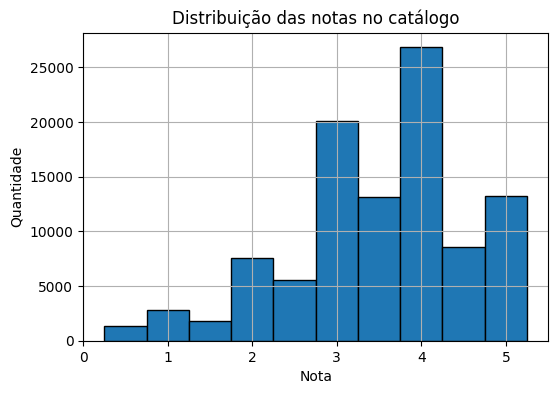

In [37]:
# Histograma de notas
plt.figure(figsize=(6,4))
ratings['rating'].hist(bins=np.arange(0.25,5.5,0.5), edgecolor="black")
plt.xlabel("Nota")
plt.ylabel("Quantidade")
plt.title("Distribuição das notas no catálogo")
plt.show()

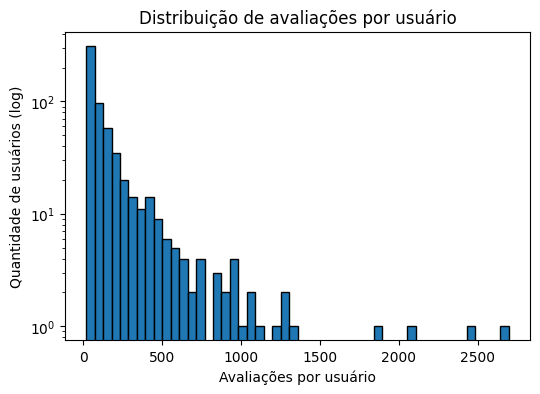

In [38]:
# Avaliações por usuário (log-scale para enxergar melhor)
plt.figure(figsize=(6,4))
plt.hist(user_movie_counts, bins=50, log=True, edgecolor="black")
plt.xlabel("Avaliações por usuário")
plt.ylabel("Quantidade de usuários (log)")
plt.title("Distribuição de avaliações por usuário")
plt.show()

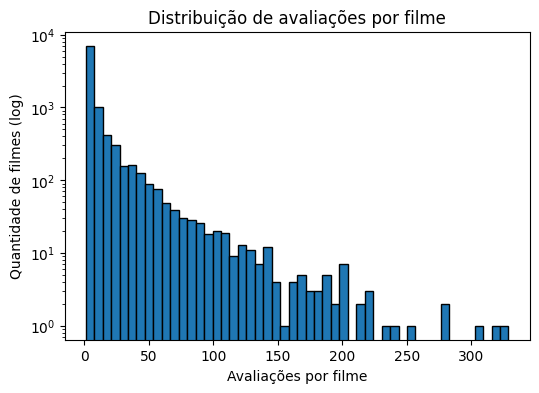

In [39]:
# Avaliações por filme
plt.figure(figsize=(6,4))
plt.hist(item_counts, bins=50, log=True, edgecolor="black")
plt.xlabel("Avaliações por filme")
plt.ylabel("Quantidade de filmes (log)")
plt.title("Distribuição de avaliações por filme")
plt.show()

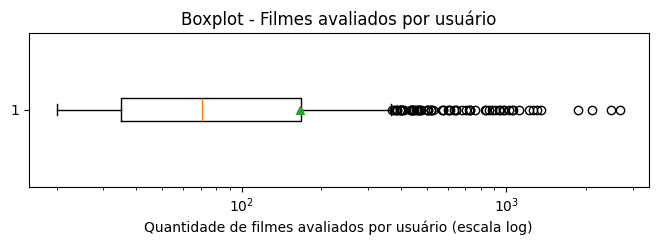

In [40]:
plt.figure(figsize=(8,2))
plt.boxplot(user_movie_counts, vert=False, showmeans=True)
plt.xscale("log")
plt.xlabel("Quantidade de filmes avaliados por usuário (escala log)")
plt.title("Boxplot - Filmes avaliados por usuário")
plt.show()


In [41]:
# Converter timestamp (unix → datetime)
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Verificar intervalo temporal
print("Período de avaliações:")
print(ratings['datetime'].min(), "→", ratings['datetime'].max())


Período de avaliações:
1996-03-29 18:36:55 → 2018-09-24 14:27:30


In [42]:
ratings

,userId,movieId,rating,timestamp,datetime
0,1,1,4.0,964982703,2000-07-30 18:45:03
1,1,3,4.0,964981247,2000-07-30 18:20:47
2,1,6,4.0,964982224,2000-07-30 18:37:04
3,1,47,5.0,964983815,2000-07-30 19:03:35
4,1,50,5.0,964982931,2000-07-30 18:48:51
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,2017-05-03 21:53:22
100832,610,168248,5.0,1493850091,2017-05-03 22:21:31
100833,610,168250,5.0,1494273047,2017-05-08 19:50:47
100834,610,168252,5.0,1493846352,2017-05-03 21:19:12


C:\Users\victo\AppData\Local\Temp\ipykernel_31696\4205438309.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ratings.set_index('datetime').resample('M')['rating'].count().plot(figsize=(10,4))


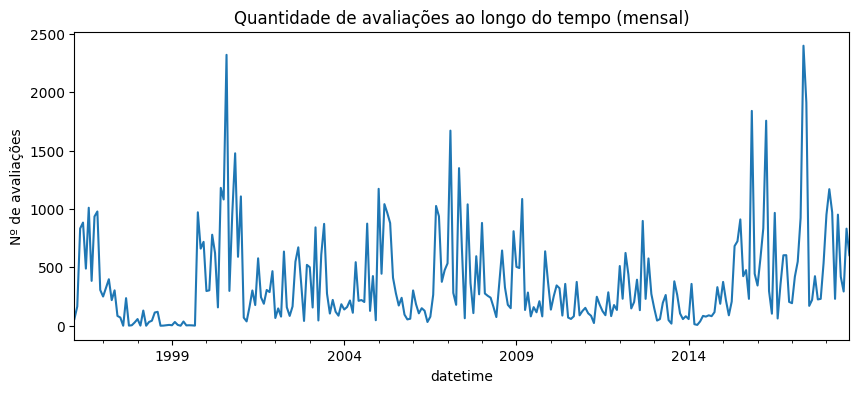

In [43]:
# Evolução ao longo do tempo
ratings.set_index('datetime').resample('M')['rating'].count().plot(figsize=(10,4))
plt.title("Quantidade de avaliações ao longo do tempo (mensal)")
plt.ylabel("Nº de avaliações")
plt.show()

In [44]:
# Média global de notas
global_mean = ratings['rating'].mean()
print("Média global das avaliações:", round(global_mean,2))

# Média de cada usuário (tendência individual)
user_mean = ratings.groupby('userId')['rating'].mean()
display(user_mean.describe())


Média global das avaliações: 3.5


count    610.000000
mean       3.657222
std        0.480635
min        1.275000
25%        3.360000
50%        3.694385
75%        3.997500
max        5.000000
Name: rating, dtype: float64

In [45]:
# Média de cada filme (popularidade/qualidade percebida)
item_mean = ratings.groupby('movieId')['rating'].mean()
display(item_mean.describe())

count    9724.000000
mean        3.262448
std         0.869874
min         0.500000
25%         2.800000
50%         3.416667
75%         3.911765
max         5.000000
Name: rating, dtype: float64

In [46]:
# Visualizar se um usuario avaliou o mesmo filme mais de uma vez
dup = ratings.duplicated(subset=["userId","movieId"]).sum()
print("Duplicatas:", dup)

Duplicatas: 0


In [47]:
# Normalizar IDs para índices (0, 1, 2, ...)
user_encoder = LabelEncoder()
movie_encoder = LabelEncoder()

ratings["user_idx"] = user_encoder.fit_transform(ratings["userId"])
ratings["movie_idx"] = movie_encoder.fit_transform(ratings["movieId"])

In [48]:
ratings.head()

,userId,movieId,rating,timestamp,datetime,user_idx,movie_idx
0,1,1,4.0,964982703,2000-07-30 18:45:03,0,0
1,1,3,4.0,964981247,2000-07-30 18:20:47,0,2
2,1,6,4.0,964982224,2000-07-30 18:37:04,0,5
3,1,47,5.0,964983815,2000-07-30 19:03:35,0,43
4,1,50,5.0,964982931,2000-07-30 18:48:51,0,46


In [49]:
# Cria a matriz usuário-item com pivot
user_item_matrix = ratings.pivot(
    index='userId',
    columns='movieId',
    values='rating'
)

print(user_item_matrix.shape)
user_item_matrix.head()

(610, 9724)


movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
# média de cada filme (ignora NaN)
item_means = user_item_matrix.mean(axis=0, skipna=True)

# notas centralizadas: (nota - média_do_filme)
centered = user_item_matrix.subtract(item_means, axis=1)

# máscara do que foi realmente avaliado (True/False)
obs_mask = ~centered.isna()

In [51]:
# Construir matriz esparsa só com observações
rows, cols = np.where(obs_mask.values)
data = centered.values[rows, cols]          # apenas notas centralizadas observadas

R = csr_matrix((data, (rows, cols)), shape=centered.shape)  # (n_users x n_items)
users = user_item_matrix.index.to_numpy()
items = user_item_matrix.columns.to_numpy()

In [52]:
# matriz (n_items x n_items). Use densa=False para poupar memória
S = cosine_similarity(R.T, dense_output=False)